# Lab09-1

Model Synthesis

## Example (DSSAT)

In this section, we review a simple crop model to demonstrate how different aspects of crop growth and development we have learned so far could be synthesized into a single model.

[The reference model](https://dssat.net/development/model-development/) was originally developed for showing how a crop model could be developed following a modular approach used by [DSSAT](https://dssat.net) which is one of the most widely used and developed collection of crop models. The sample model was coded in Fortran 90 and published as a part of [research report](http://dssat.net/wp-content/uploads/2014/03/modular.pdf) in 1999.

![Schematic of modular structure](https://dssat.net/wp-content/uploads/2014/03/program.gif)

It consists of two modules representing plant and soil water which shares a common weather data structure. The model is modular that a module is composed of components separated in a code block to handle distintive steps of processing including **initialization**, **rate calculation**, **integration**, **output**, and **close**.

![Structure of the example model](https://dssat.net/wp-content/uploads/2014/03/figure1.gif)

A typical implementation of this structure adopted by DSSAT and other similar crop models including [APSIM](https://www.apsim.info) is to first build a main driver for managing other modules.

![Driver for managing modules](https://dssat.net/wp-content/uploads/2014/03/figure2.gif)

Then each module is built in a way to describe separate logics for different aspects of the process (*i.e.* separation of rate calculation and integration). DSSAT usually implements these logics in code blocks separated by `if-else` conditions contained in a single large function.

![Modular implementation of module](https://dssat.net/wp-content/uploads/2014/03/figure3.gif)

### Weather.for

Weather data used by the model is stored in a file named "WEATHER.INP" in a textual format similar to TSV (tab-separated values) file. `WEATHR()` function is called for each time step to refresh weather-related variables like `DATE`, `PAR`, `RAIN`, `TMAX` and `TMIN`. The file is loaded in the `INITIAL` stage and each row of the data is read in the `RATE` stage, until the file is closed in the `CLOSE` stage. The stage is determined by a control variable named `DYN` (dynamic).

### Plant.for

`PLANT()` function implements most of physiological processes involved in this model including carbon assimilation, carbon allocation, leaf area expansion, and phenology development.

Some parameters are first loaded from `PLANT.INP` file in the `INITIAL` stage. Rate variables are calculated in the `RATE` stage and state variables are integrated (*accumulated* in Cropbox terms) in the `INTEG` stage. At a certain time interval (for every 3 time step by default), a snapshot of some variables are written into an output file in the `OUTPUT` stage. Files are all closed in the `CLOSE` stage when simulation is over.

Some code describing a complex logic like `LAIS()` for calculating an amount of leaf area expansion, `PGS()` for calculating canopy gross photosynthesis rate, and `PTS()` for calculating temperature effect factor on photosynthesis are implemented in separate functions. Calculation of all other variables are laid out in a code block corresponding to the stages. Developers may need to pay attention to the order of calcuation as the code will be executed in the same order as the code is laid out.

Separation of logics depending on phenology development is implemented by tracking a flag variable `FL` encoding development phase: 1 for vegetative, 2 for reproductive.

Carbon assimilation (photosyntesis) is based on empirical RUE (radiation use efficiency) approach. Carbon allocation is driven by a partitional table which changes by development phase. Leaf area expansion is also affected by phenology. On vegetative phase, leaf area increases by the number of leaves along with water and temperature conditions. On reproductive stage, leaf area decreases by accumualted thermal time.

For detailed explanations on the equations, please refer to the [model document](https://dssat.net/development/model-development/).

Note that soil water stress factor (`SWFAC`) comes from soil water module which will be discussed later.

### Sw.for

Soil water balance is represented by a simple bucket model with a single homogeneous layer. A  few parameters representing soil characterstics such as `WPp` (volumetric water content at wilting point), `FCp` (VWC at field capacity, `STp` (VWC at saturation) are loaded from configuration file `SOIL.INP`.

`RAIN` (precipitation) is already provided by weather module. `IRR` (irrigation) is then loaded from a separate time-series data file named `IRRIG.INP`.

Other rate variables like `ESa` (actual soil evaporation), `EPa` (actual plant transpiration), `ROF` (runoff), `DRN` (drainage), and `INF` (infiltration) are calculated in the `RATE` stage. The total amount for each variable is then calculated in the `INTEG` stage resulting into accumulated variables like `TRAIN`, `TIRR`, `TESA`, `TEPA`, `TROF`, `TDRN`, and `TINF`.

`SWC` (soil water content) is calculated each step with regards to the relation in the form of `SWC = SWC + (INF - ESa - EPa - DRN)`. Note that the original model was implemented in a slightly confusing manner that some rate variables like `ROF` are still updated in the integration stage.

Two types of soil water stress factor `SWFAC1` (deficit) and `SWFAC2` (excess) are calculated in the function `STRESS()`. More severe (lower) value from either of them becomes `SWFAC` (soil water stress factor) used in the plant module.

For detailed explanations on the equations, please refer to the [model document](https://dssat.net/development/model-development/). The image below from [APSIM](https://www.apsim.info), another widely used crop modeling platform, gives a good picture of how soil water balance model works in general.

![](https://s2.studylib.net/store/data/005700874_1-01e3dd89e7fd05bb4ad2aa5d1621b8f0.png)

### Main.for

The `Main` driver is where all modules gather. Again, depending on the current stage controlled by `DYN`, a representative function for each module will be called: `PLANT()` for plant module, `SW()` for soil water module, and `WEATHR()` for weather module.

Duration of simulation is determined by a few conditions including hard-coded maximum DOY of 1000 and `endsim` variable turned on after a certain thermal accumulation thershold. Frequency of output recording is also determined by a parameter named `FROP`.

Overall, what a driver is reponsible for often corresponds to what `simulate()` function does in Cropbox.

## Cropbox

Now let's build this model with Cropbox.

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6470092624181913826\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-7959030094210344523\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6470092624181913826\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Weather

In [3]:
using Cropbox.CSV
using Cropbox.DataFrames
using Cropbox.TimeZones
using Dates

In [4]:
@system Weather(DateStore) begin
    filename => "simple/weather.csv" ~ preserve::String(parameter)
    datekey => :DATE ~ preserve::Symbol(parameter)

    DATE(s) ~ drive::Date

    SRAD(s): solar_radiation ~ drive(u"MJ/m^2/d")
    #PAR(s): photosynthetically_active_radiation ~ drive(u"MJ/m^2/d")
    PAR(SRAD): photosynthetically_active_radiation => 0.5SRAD ~ track(u"MJ/m^2/d")

    TMAX(s): maximum_temperature ~ drive(u"°C")
    TMIN(s): minimum_temperature ~ drive(u"°C")
    TMN(TMAX, TMIN): mean_temperature => begin
        # explicit conversion due to strictness of temperature units handling by Unitful.jl
        0.5(u"K"(TMAX) + u"K"(TMIN))
    end ~ track(u"°C")

    RAIN(s): rainfall ~ drive(u"mm/d")
end

Weather

In [5]:
@system WeatherController(Weather, Controller)

WeatherController

In [6]:
weather_config = @config (
    :Clock => :step => 1u"d",
    :Calendar => :init => ZonedDateTime(1986, 1, 1, tz"UTC"),
)

Config for 2 systems:
  Clock
    step = 1 d
  Calendar
    init = ZonedDateTime(1986, 1, 1, tz"UTC")

In [7]:
simulate(WeatherController;
    config = weather_config,
    stop = 7u"d",
    index = :DATE,
    target = [:PAR, :TMAX, :TMIN, :TMN, :RAIN],
)

Progress: 100%[=========================================] Time: 0:00:02


8×6 DataFrame
 Row │ DATE        PAR                TMAX       TMIN       TMN        RAIN    ⋯
     │ Date        Quantity…          Quantity…  Quantity…  Quantity…  Quantit ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1986-01-01  3.15 MJ d^-1 m^-2    22.8 °C    13.9 °C   18.35 °C  22.6 mm ⋯
   2 │ 1986-01-02  3.15 MJ d^-1 m^-2    20.6 °C    12.8 °C    16.7 °C   0.0 mm
   3 │ 1986-01-03   3.1 MJ d^-1 m^-2    20.6 °C    13.3 °C   16.95 °C   0.3 mm
   4 │ 1986-01-04  2.45 MJ d^-1 m^-2    23.3 °C    15.6 °C   19.45 °C   0.5 mm
   5 │ 1986-01-05   5.4 MJ d^-1 m^-2    20.6 °C    11.1 °C   15.85 °C  40.4 mm ⋯
   6 │ 1986-01-06  7.45 MJ d^-1 m^-2    17.8 °C    -1.7 °C    8.05 °C   0.0 mm
   7 │ 1986-01-07  1.45 MJ d^-1 m^-2    14.4 °C     6.7 °C   10.55 °C   7.6 mm
   8 │ 1986-01-08   1.2 MJ d^-1 m^-2    11.7 °C     7.2 °C    9.45 °C   0.8 mm
                                                                1 column omitted

### Plant

In [8]:
@system Plant begin
    # make sure we have a correct time interval when doing accumulation (i.e. we may use a non-daily time step)
    Δt(context.clock.step): timestep ~ preserve(u"d")
    t(context.clock.tick): timestamp ~ track(u"d")

    DATE ~ hold
    # added for convenience
    DOY(DATE) => dayofyear(DATE) ~ track::Int(u"d")
    # moved from Main
    DOYP: planting_day_of_year => 121 ~ preserve::Int(u"d", parameter)

    TMAX: maximum_temperature ~ hold
    TMIN: minimum_tempearture ~ hold
    TMN: mean_temperature ~ hold
    PAR: photosynthetically_active_radiation ~ hold

    SWFAC: soil_water_stress_factor ~ hold

    # distinguish initial values of variables (parameters) from actual variables being updated (i.e. LAI0, N0)
    EMP1: LAI_coeff1 => 0.104 ~ preserve(u"m^2", parameter)
    EMP2: LAI_coeff2 => 0.64 ~ preserve(parameter)
    Fc: canopy_fraction => 0.85 ~ preserve(parameter)
    sla: specific_leaf_area => 0.028 ~ preserve(u"m^2/g")
    INTOT: duration_of_reproductive_stage => 300.0 ~ preserve(u"K", parameter)
    LAI0: initial_leaf_area_index => 0.013 ~ preserve(u"m^2/m^2", parameter)
    Lfmax: maximum_leaf_number => 12.0 ~ preserve(parameter)
    N0: initial_leaf_number => 2.0 ~ preserve(parameter)
    nb: LAI_coeff => 5.3 ~ preserve(parameter)
    # correct units for p1 (g/K, not g)
    p1: leaf_senescence_rate => 0.03 ~ preserve(u"g/K", parameter)
    PD: plant_density => 5.0 ~ preserve(u"m^-2", parameter)
    rm: maximum_leaf_appearance_rate => 0.100 ~ preserve(u"d^-1", parameter)
    tb: base_temperature => 10.0 ~ preserve(u"°C", parameter)
    W0: initial_plant_dry_matter => 0.3 ~ preserve(u"g/m^2", parameter)
    Wc0: initial_canopy_dry_matter => 0.045 ~ preserve(u"g/m^2", parameter)
    Wr0: initial_root_dry_matter => 0.255 ~ preserve(u"g/m^2", parameter)

    # handle empirical equation for temperature (nounit)
    PT(nounit(TMIN), nounit(TMAX)): photosynthesis_reduction_factor_for_temp => begin
        1.0 - 0.0025 * ((0.25TMIN + 0.75TMAX) - 26.0)^2
    end ~ track

    # introduce RUE parameter with proper units
    RUE: radiation_use_efficiency => 2.1 ~ preserve(u"g/MJ", parameter)
    Pg(PT, SWFAC, RUE, PAR, PD, Y1, LAI): potential_growth_rate => begin
        PT * SWFAC * RUE * PAR/PD * (1 - ℯ^(-Y1 * LAI))
    end ~ track(u"g/d")

    ROWSPC: row_spacing => 60.0 ~ preserve(u"cm", parameter)
    Y1(ROWSPC, PD): canopy_light_extinction_coeff => begin
        # no need to convert units for ROWSPC
        1.5 - 0.768 * (ROWSPC^2 * PD)^0.1
    end ~ preserve

    # introduce flags for organizing rate calculations depending on development phases
    P(DOY, DOYP): planted => (DOY >= DOYP) ~ flag
    VP(P, N, Lfmax): vegetative_phase => (P && N < Lfmax) ~ flag
    RP(N, Lfmax): reproductive_phase => (N >= Lfmax) ~ flag
    # development phase code no longer needed
    FL(VP, RP): development_phase_code => (VP ? 1 : RP ? 2 : 0) ~ track

    dN(rm, PT): leaf_number_increase => rm * PT ~ track(u"d^-1", when=VP)
    N(dN): leaf_number ~ accumulate(init=N0, when=VP)

    di(TMN, tb, Δt): daily_accumulated_temperature => begin
        tb <= TMN <= 25u"°C" ? TMN - tb : 0
    end ~ track(u"K", when=RP)
    INT(di, Δt) => di / Δt ~ accumulate(u"K", when=RP)

    _a(EMP2, N, nb) => exp(EMP2 * (N - nb)) ~ track
    dLAI1(SWFAC, PD, EMP1, PT, _a, dN) => begin
        SWFAC * PD * EMP1 * PT * (a/(1+a)) * dN
    end ~ track(u"m^2/m^2/d", when=VP)
    dLAI2(PD, di, p1, sla) => begin
        -PD * di * p1 * sla
    end ~ track(u"m^2/m^2/d", when=RP)
    dLAI(dLAI1, dLAI2): leaf_area_index_increase => dLAI1 + dLAI2 ~ track(u"m^2/m^2/d")
    LAI(dLAI): leaf_area_index ~ accumulate(u"m^2/m^2", init=LAI0)

    E: CH2O_conversion_efficiency => 1.0 ~ preserve(u"g/g", parameter)
    dW(E, Pg, PD) => E * Pg * PD ~ track(u"g/m^2/d")
    W(dW): plant_dry_matter ~ accumulate(u"g/m^2", init=W0, when=P)
    Wc(Fc, dW): canopy_dry_matter => Fc * dW ~ accumulate(u"g/m^2", init=Wc0, when=VP)
    Wr(Fc, dW): root_dry_matter => (1-Fc) * dW ~ accumulate(u"g/m^2", init=Wr0, when=VP)
    Wf(dW): fruit_dry_matter ~ accumulate(u"g/m^2", when=RP)

    endsim(INT, INTOT): end_of_simulation => (INT > INTOT) ~ flag
end

Plant

### Soil Water

By the way, loading `IRR` from `irrigation.csv` is not implemented yet due to time constraints. It should be okay here though since the original dataset had zero irrigation for the entire term of simulation.

In [9]:
@system SoilWater begin
    # make sure we have a correct time interval when doing accumulation (i.e. we may use a non-daily time step)
    Δt(context.clock.step): timestep ~ preserve(u"hr")

    SRAD: solar_radiation ~ hold
    TMAX: maximum_temperature ~ hold
    TMIN: minimum_temperature ~ hold
    RAIN: rainfall ~ hold
    IRR => 0 ~ track(u"mm/d")
    LAI: leaf_area_index ~ hold

    CN: runoff_curve_number => 55 ~ preserve(parameter)
    DP: soil_profile_depth => 145 ~ preserve(u"cm", parameter)
    DRNp: daily_drainage => 0.1 ~ preserve(u"cm^3/cm^3/d", parameter)
    WPp: soil_water_portion_at_wilting_point => 0.06 ~ preserve(u"cm^3/cm^3", parameter)
    FCp: soil_water_portion_at_field_capacity => 0.17 ~ preserve(u"cm^3/cm^3", parameter)
    STp: soil_water_portion_at_saturation => 0.28 ~ preserve(u"cm^3/cm^3", parameter)
    SWC0: initial_soil_water_content => 246.5 ~ preserve(u"mm", parameter)

    # no need for manual conversion from cm to mm (DP*10)
    WP(DP, WPp): soil_water_content_at_wilting_point => DP * WPp ~ preserve(u"mm")
    FC(DP, FCp): soil_water_content_at_field_capacity => DP * FCp ~ preserve(u"mm")
    ST(DP, STp): soil_water_content_at_saturation => DP * STp ~ preserve(u"mm")

    # no need for manual conversion from inch to mm (25.4 mm/inch)
    S(CN): potential_maximum_soil_moisture_retention_after_runoff => begin
        1000/CN - 10
    end ~ preserve(u"inch/d")

    POTINF(RAIN, IRR): potential_infiltration => RAIN + IRR ~ track(u"mm/d")
    ROF(POTINF, S, dROF_extra): runoff => begin
        if POTINF > 0.2S
            (POTINF - 0.2S)^2 / (POTINF + 0.8S)
        else
            0u"mm/d"
        end + dROF_extra
    end ~ track(u"mm/d")
    INF(POTINF, ROF): infiltration => POTINF - ROF ~ track(u"mm/d")

    THE(WP, FC): soil_water_content_threshold => WP + 0.75(FC - WP) ~ preserve(u"mm")

    TRAIN(RAIN): cumulative_rainfall ~ accumulate(u"mm")
    TIRR(IRR): cumulative_irrigation ~ accumulate(u"mm")
    TESa(ESa): cumulative_soil_evaporation ~ accumulate(u"mm")
    TEPa(EPa): cumulative_plant_transpiration ~ accumulate(u"mm")
    TROF(ROF): cumulative_runoff ~ accumulate(u"mm")
    TDRN(DRN): cumulative_vertical_drainage ~ accumulate(u"mm")
    TINF(INF): cumulative_infiltration ~ accumulate(u"mm")

    DRN(SWC, FC, DRNp): vertical_drainage => (SWC - FC) * DRNp ~ track(u"mm/d", min=0)

    # make soil/crop albedo parameters
    αs: soil_albedo => 0.1 ~ preserve(parameter)
    αc: crop_albedo => 0.2 ~ preserve(parameter)
    ALB(LAI, αs, αc): surface_albedo => αs * ℯ^(-0.7LAI) + αc * (1 - ℯ^(-0.7LAI)) ~ track

    Tmed(TMAX, TMIN) => 0.6u"K"(TMAX) + 0.4u"K"(TMIN) ~ track(u"°C")

    # match units of Priestly-Taylor equations
    # http://www.clw.csiro.au/publications/technical98/tr34-98.pdf
    # handle temperature units correctly (°C vs. K)
    EEQ(SRAD, ALB, Tmed): equilibrium_evaporation => begin
        SRAD * (4.88e-3 - 4.37e-3ALB)u"mm^3/J/K" * (Tmed - 0u"°C" + 29u"K")
    end ~ track(u"mm/d")

    # handle empirical equation for temperature (nounit)
    f(nounit(TMAX)) => begin
        if TMAX < 5
            0.01ℯ^(0.18(TMAX + 20))
        elseif TMAX > 35
            1.1 + 0.05(TMAX - 35)
        else
            1.1
        end
    end ~ track
    ETp(f, EEQ): potential_evapotranspiration => f * EEQ ~ track(u"mm/d")
    ESp(ETp, LAI): potential_soil_evaporation => ETp * ℯ^(-0.7LAI) ~ track(u"mm/d")
    EPp(ETp, LAI): potential_plant_transpiration => ETp * (1 - ℯ^(-0.7LAI)) ~ track(u"mm/d")

    _a(SWC, WP, FC) => begin
        if SWC < WP
            0
        elseif SWC > FC
            1
        else
            (SWC - WP) / (FC - WP)
        end
    end ~ track
    ESa(ESp, _a): soil_evaporation => ESp * a ~ track(u"mm/d")
    EPa(EPp, SWFAC): plant_transpiration => EPp * SWFAC ~ track(u"mm/d")

    dSWC(INF, ESa, EPa, DRN, dROF_extra, dSWC_ADJ)=> begin
        INF - ESa - EPa - DRN - dROF_extra + dSWC_ADJ
    end ~ track(u"mm/d")

    # these seemingly complicated extra/adj variables are due to incomplete separation of rate variable calculation and integration logic in the original model
    # handle ROF update w.r.t SWC overflow
    dROF_extra(SWC, ST, Δt) => (SWC - ST) / Δt ~ track(u"mm/d", min=0)
    # handle SWC_ADJ w.r.t SWC underflow
    dSWC_ADJ(SWC, Δt) => -SWC / Δt ~ track(u"mm/d", min=0)
    SWC_ADJ(dSWC_ADJ) ~ accumulate(u"mm")

    SWC(dSWC): soil_water_content ~ accumulate(u"mm", init=SWC0)
    ΔSWC(SWC0, SWC): storage_change => SWC0 - SWC ~ track(u"mm")

    Fi(TRAIN, TIRR) => TRAIN + TIRR ~ track(u"mm")
    Fo(TESa, TEPa, TROF, TDRN) => TESa + TEPa + TROF + TDRN ~ track(u"mm")
    WATBAL(ΔSWC, Fi, Fo) => ΔSWC + Fi - Fo ~ track(u"mm")

    CHECK(TRAIN, TIRR, TROF) => TRAIN + TIRR - TROF ~ track(u"mm")

    # if-else logic replaced by min=0, max=1
    SWFAC1(SWC, WP, THE): drought_stress_factor => (SWC - WP) / (THE - WP) ~ track(min=0, max=1)

    # no need for manual conversion from cm to mm (DP*10)
    WTABLE(SWC, FC, ST, DP): water_table_thickness => (SWC - FC) / (ST - FC) * DP ~ track(u"mm", min=0)
    DWT(DP, WTABLE): water_table_depth => DP - WTABLE ~ track(u"mm")

    STRESS_DEPTH: water_table_depth_threshold => 250 ~ preserve(u"mm", parameter)
    # if-else logic replaced by max=1
    SWFAC2(DWT, STRESS_DEPTH): excess_stress_factor => DWT / STRESS_DEPTH ~ track(min=0, max=1)

    SWFAC(SWFAC1, SWFAC2): soil_water_stress_factor => min(SWFAC1, SWFAC2) ~ track
end

SoilWater

### Main

By the way, we can't name our model `Main` since the name is reserved for Julia. Remember all variables we declare in the default Julia session are bound to `Main` scope.

In [10]:
@system Model(Plant, SoilWater, Weather, Controller)

Model

We have two years (1986, 1987) of weather data for testing simulation. The model assumes daily time step.

In [11]:
config = @config (
    :Clock => :step => 1u"d",
    :Calendar => :init => ZonedDateTime(1987, 1, 1, tz"UTC")
)

Config for 2 systems:
  Clock
    step = 1 d
  Calendar
    init = ZonedDateTime(1987, 1, 1, tz"UTC")

Simulation `stop` condition is determined by `endsim` variable defined in the plant module.

In [12]:
stop = :endsim

:endsim

If we want to replicate the behavior of original model printing output for every 3 days, we can set up `snap` callback for `simulate()`.

In [13]:
# frequency of printout (days)
FROP = 3u"d"

3 d

In [14]:
snap = s -> iszero(s.DOY' % FROP)

#19 (generic function with 1 method)

Let's stick to the default `snap` behavior that collects simulation output for every time step for now though.

In [15]:
snap = nothing

## Results

In [16]:
r = simulate(Model; config, stop, snap)

Iterations: 294 	 Time: 0:00:36


295×109 DataFrame
 Row │ tick       Δt         t          DATE        DOY        DOYP       TMAX ⋯
     │ Quantity…  Quantity…  Quantity…  Date        Quantity…  Quantity…  Quan ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.0 hr    24.0 hr      0.0 d  1987-01-01        1 d      121 d    20 ⋯
   2 │   24.0 hr    24.0 hr      1.0 d  1987-01-02        2 d      121 d    13
   3 │   48.0 hr    24.0 hr      2.0 d  1987-01-03        3 d      121 d    14
   4 │   72.0 hr    24.0 hr      3.0 d  1987-01-04        4 d      121 d    18
   5 │   96.0 hr    24.0 hr      4.0 d  1987-01-05        5 d      121 d    17 ⋯
   6 │  120.0 hr    24.0 hr      5.0 d  1987-01-06        6 d      121 d    21
   7 │  144.0 hr    24.0 hr      6.0 d  1987-01-07        7 d      121 d    21
   8 │  168.0 hr    24.0 hr      7.0 d  1987-01-08        8 d      121 d    21
   9 │  192.0 hr    24.0 hr      8.0 d  1987-01-09        9 d      121 d    20 ⋯
  10 │  216.0 hr    24.0 hr      9.0 d  1987-01-10       10 d      121 d    23
  11 │  240.0 hr    24.0 hr     10.0 d  1987-01-11       11 d      121 d    19
  ⋮  │     ⋮          ⋮          ⋮          ⋮           ⋮          ⋮           ⋱
 286 │ 6840.0 hr    24.0 hr    285.0 d  1987-10-13      286 d      121 d    21
 287 │ 6864.0 hr    24.0 hr    286.0 d  1987-10-14      287 d      121 d    22 ⋯
 288 │ 6888.0 hr    24.0 hr    287.0 d  1987-10-15      288 d      121 d    24
 289 │ 6912.0 hr    24.0 hr    288.0 d  1987-10-16      289 d      121 d    27
 290 │ 6936.0 hr    24.0 hr    289.0 d  1987-10-17      290 d      121 d    29
 291 │ 6960.0 hr    24.0 hr    290.0 d  1987-10-18      291 d      121 d    29 ⋯
 292 │ 6984.0 hr    24.0 hr    291.0 d  1987-10-19      292 d      121 d    31
 293 │ 7008.0 hr    24.0 hr    292.0 d  1987-10-20      293 d      121 d    31
 294 │ 7032.0 hr    24.0 hr    293.0 d  1987-10-21      294 d      121 d    28
 295 │ 7056.0 hr    24.0 hr    294.0 d  1987-10-22      295 d      121 d    22 ⋯
                                                103 columns and 274 rows omitted

### Leaf Development

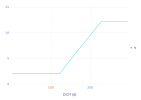

In [17]:
plot(r, :DOY, :N, kind=:line, ylim=(0,15))

### Leaf Area Expansion

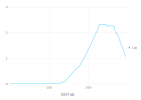

In [18]:
plot(r, :DOY, :LAI, kind=:line)

### Carbon Allocation

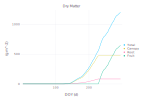

In [19]:
plot(r, :DOY, [:W, :Wc, :Wr, :Wf];
    title = "Dry Matter",
    names = ["Total", "Canopy", "Root", "Fruit"],
    kind = :line,
)

### Phenology

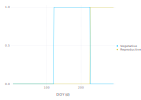

In [20]:
plot(r, :DOY, [:VP, :RP];
    names = ["Vegetative", "Reproductive"],
    kind = :line,
)

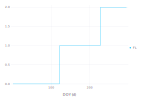

In [21]:
plot(r, :DOY, :FL, kind=:line)

### Soil Water Content

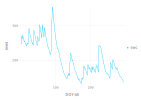

In [22]:
plot(r, :DOY, :SWC, kind=:line)

### Water Stress Factor

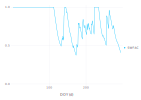

In [23]:
plot(r, :DOY, :SWFAC, kind=:line)

## Analysis

### Leaf Development

Leaf development in this model is mainly controlled by three related parameters: initial leaf number (`N0`), maximum leaf number (`Lfmax`), and maximum leaf appearance rate (`rm`). Actual leaf appearance rate (`dN`) is adjusted by temperature effect (`PT`), but thermal time unit is not directly involved in this process.

In [24]:
manipulate(Model, :DOY, :N; config, stop, snap,
    parameters = (
        :Plant => (;
            N0 = 0:5,      # initial_leaf_number
            Lfmax = 10:20, # maximum_leaf_number
            rm = 0:0.01:1, # maximum_leaf_appearance_rate
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 20),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Plant"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["N0"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 5,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 1 listeners. Value:
2, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c59898c40, Task (runnable) @0x00007f9c59898c40), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n    

### Leaf Area Expansion

Although quite a number of parameters are in control of leaf area expansion, they are mostly empricial that it's hard to figure out their physiological meanings. Reduction of LAI on the reproductive stage is mainly controlled by leaf senescene rate (`p1`) and thermal unit (`di`). A jaggedness of decreasing LAI lends to `di` being discrete.

In [25]:
manipulate(Model, :DOY, :LAI; config, stop, snap,
    parameters = (
        :Plant => (;
            nb = 0.1:0.1:10,       # LAI_coeff
            EMP1 = 0.01:0.01:0.3,  # LAI_coeff1
            EMP2 = 0.1:0.1:1,      # LAI_coeff2
            sla = 0.001:0.001:0.1, # specific_leaf_area
            p1 = 0.001:0.001:0.1,  # leaf_senescence_rate
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 5),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Plant"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["nb"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c3a2add50, Task (runnable) @0x00007f9c3a2add50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

### Thermal Accumulation

In this model, thermal accumulation is only used for deciding the duration of reproductive stage. The total thermal units (`DI`) starts accumulating with the onset of reproductive stage and stops when it reaches a threshold (`INTOT`).

In [26]:
manipulate(Model, :DOY, :INT; config, stop, snap,
    parameters = (
        :Plant => (;
            tb = 0:12,       # base_temperature
            INTOT = 100:400, # duration_of_reproductive_stage
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 400),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Plant"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["tb"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 12,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 1 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c39b5b0d0, Task (runnable) @0x00007f9c39b5b0d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

### Carbon Assimilation

With a simple RUE approach, there are not many parameters other than `RUE` that we can control for photosynthesis process. For an area-based carbon assimilation, plant density (`PD`) and row spacing (`ROWSPC`) can scale up and down the total amount of production as well.

In [27]:
manipulate(Model, :DOY, [:W, :Wc, :Wr, :Wf]; config, stop, snap,
    parameters = (
        :Plant => (;
            RUE = 0:0.1:5,   # radiation_use_efficiency
            PD = 0.1:0.1:10, # plant_density
            ROWSPC = 1:100,  # row_spacing
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 2000),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Plant"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["RUE"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 51,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c39b5a980, Task (runnable) @0x00007f9c39b5a980), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n   

### Carbon Allocation

Initial dry matter parameters (`W0`, `Wc0`, `Wr0`) doesn't have much sensitivity since dry matter growth rate (`dW`) soley relies on the current photosynthesis rate (`Pg`), not on an existing biomass. Canopy fraction (`Fc`) determines the ratio between canopy and root. Phenology-related parameters such as maximum leaf number (`Lfmax`) also plays an important role since they decide the timing of reproductive phase.

In [28]:
manipulate(Model, :DOY, [:W, :Wc, :Wr, :Wf]; config, stop, snap,
    parameters = (
        :Plant => (;
            W0 = 0.1:0.1:1,      # initial_plant_dry_matter
            Wc0 = 0.01:0.01:0.3, # initial_canopy_dry_matter
            Wr0 = 0.01:0.01:0.3, # initial_root_dry_matter
            Fc = 0:0.01:1,       # canopy_fraction
            Lfmax = 5:20,        # maximum_leaf_number
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 1000),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Plant"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["W0"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c24887a90, Task (runnable) @0x00007f9c24887a90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n     

### Temperature Offset

Let's say we're interested in temperature effect on crop yield. Without fiddling with temperature data stored in the input file, we instead extend the model to accept temperature offset parameters (`ΔTMAX`, `ΔTMIN`) for the sake of simplicity.

In [29]:
@system ModelT(Model, Controller) begin
    ΔTMAX: maximum_temperature_offset => 0 ~ preserve(u"K", parameter)
    ΔTMIN: minimum_temperature_offset => 0 ~ preserve(u"K", parameter)

    TMAX(s, ΔTMAX): maximum_temperature => s[:TMAX] + ΔTMAX ~ track(u"°C")
    TMIN(s, ΔTMIN): minimum_temperature => s[:TMIN] + ΔTMIN ~ track(u"°C")
end

ModelT

In [30]:
manipulate(ModelT, :DOY, [:TMAX, :TMN, :TMIN]; config, stop=364u"d",
    parameters = (
        :ModelT => (;
            ΔTMAX = -10:10,
            ΔTMIN = -10:10,
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (-5, 45),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["ModelT"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["ΔTMAX"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => -10,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 1 listeners. Value:
0, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c39418760, Task (runnable) @0x00007f9c39418760), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context

In [31]:
manipulate(ModelT, :DOY, [:W, :Wc, :Wr, :Wf]; config, stop, snap,
    parameters = (
        :ModelT => (;
            ΔTMAX = -10:10,
            ΔTMIN = -10:10,
        ),  
    ),
    kind = :line,
    xlim = (0, 365),
    ylim = (0, 1000),
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["ModelT"], Dict{Symbol,Any}(:style => Dict{String,Any}("color" => :darkorchid,"font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["ΔTMAX"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px","color" => :royalblue)))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 10,:min => -10,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget",:style => Dict("font-family" => "monospace","width" => "25%"))), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 1 listeners. Value:
0, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/srv/julia/pkg/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/all.js"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/InteractBase/sOe2Z/src/../assets/style.css"), WebIO.Asset("css", nothing, "/srv/julia/pkg/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{WebIO.AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f9c24c44c40, Task (runnable) @0x00007f9c24c44c40), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context